# Day 2: Advanced Analytics & Machine Learning with PySpark

**Workshop Schedule:**
- 13:00-13:45: Regressionsanalyse mit PySpark ML
- 13:55-14:40: Unstructured Data Analytics mit Spark NLP  
- 14:50-15:40: Big Data Visualization & Spark DataFrame Deep-Dive

## Dataset Overview

We'll be working with the **full 13M+ transactions dataset** using PySpark:
- **13M+ transaction records** (no sampling needed!)
- **Fields:** id, date, client_id, card_id, amount, use_chip, merchant_id, merchant_city, merchant_state, zip, mcc, errors
- **Time Range:** 2010+ banking transactions
- **Use Cases:** Scalable fraud detection, customer analytics, risk scoring
- **Processing:** Distributed computing with Apache Spark

In [24]:
# Import PySpark and related libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression as SparkLogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.window import Window

# Traditional ML and visualization (for model evaluation)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [25]:
# Initialize Spark Session with optimized configuration
spark = SparkSession.builder \
    .appName("BankingAnalytics") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Set log level to reduce verbose output
spark.sparkContext.setLogLevel("WARN")

print(f"Spark Version: {spark.version}")
print(f"Available cores: {spark.sparkContext.defaultParallelism}")

Spark Version: 3.5.3
Available cores: 8


In [26]:
# Load the FULL dataset with PySpark (no sampling!)
print("Loading full 13M+ transaction dataset...")

# Define schema for better performance
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("date", TimestampType(), True),
    StructField("client_id", IntegerType(), True),
    StructField("card_id", IntegerType(), True),
    StructField("amount", StringType(), True),
    StructField("use_chip", StringType(), True),
    StructField("merchant_id", IntegerType(), True),
    StructField("merchant_city", StringType(), True),
    StructField("merchant_state", StringType(), True),
    StructField("zip", DoubleType(), True),
    StructField("mcc", IntegerType(), True),
    StructField("errors", StringType(), True)
])

# Load data with optimized settings
df_spark = spark.read.csv(
    "../data/transactions_data.csv",
    header=True,
    schema=schema,
    timestampFormat="yyyy-MM-dd HH:mm:ss"
)

# Cache the DataFrame for better performance
df_spark.cache()

print(f"Dataset loaded successfully!")
print(f"Total rows: {df_spark.count():,}")
print(f"Number of partitions: {df_spark.rdd.getNumPartitions()}")

df_spark.printSchema()
df_spark.show(5)

Loading full 13M+ transaction dataset...
Dataset loaded successfully!
Total rows: 13,305,915
Number of partitions: 10
root
 |-- id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- card_id: integer (nullable = true)
 |-- amount: string (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- merchant_state: string (nullable = true)
 |-- zip: double (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- errors: string (nullable = true)

+-------+-------------------+---------+-------+-------+-----------------+-----------+-------------+--------------+-------+----+------+
|     id|               date|client_id|card_id| amount|         use_chip|merchant_id|merchant_city|merchant_state|    zip| mcc|errors|
+-------+-------------------+---------+-------+-------+-----------------+-----------+-------------+--------------+-------+----+-

25/08/10 21:45:06 WARN CacheManager: Asked to cache already cached data.


---

# 📊 13:00-13:45: Regressionsanalyse mit PySpark ML

## 🎯 Lernziele:
- Distributed Linear Regression für Customer Lifetime Value
- Scalable Logistic Regression für Fraud Detection
- PySpark ML Pipeline für Credit Risk Scoring
- Big Data Model Evaluation Metriken

## 1. Distributed Data Preprocessing

In [27]:
# Advanced preprocessing with Spark SQL functions
df_processed = df_spark \
    .withColumn("amount_numeric", regexp_replace(col("amount"), "[\$,]", "").cast("double")) \
    .withColumn("is_online", (col("merchant_city") == "ONLINE").cast("int")) \
    .withColumn("is_weekend", dayofweek(col("date")).isin([1, 7]).cast("int")) \
    .withColumn("hour", hour(col("date"))) \
    .withColumn("month", month(col("date"))) \
    .withColumn("weekday", date_format(col("date"), "EEEE")) \
    .withColumn("year", year(col("date"))) \
    .filter(col("amount_numeric").isNotNull() & (col("amount_numeric") > 0))

# Add fraud indicators using distributed computing
amount_95th = df_processed.approxQuantile("amount_numeric", [0.95], 0.01)[0]

df_processed = df_processed \
    .withColumn("unusual_amount", (col("amount_numeric") > amount_95th).cast("int")) \
    .withColumn("night_transaction", ((col("hour") < 6) | (col("hour") > 22)).cast("int")) \
    .withColumn("round_amount", (col("amount_numeric") % 10 == 0).cast("int"))

# Create synthetic fraud labels (distributed random generation)
from pyspark.sql.functions import rand

df_processed = df_processed \
    .withColumn("fraud_probability", 
                col("unusual_amount") * 0.3 + 
                col("night_transaction") * 0.2 + 
                col("is_online") * 0.1 + 
                col("round_amount") * 0.1) \
    .withColumn("is_fraud", (rand(42) < col("fraud_probability") * 0.1).cast("int"))

# Cache the processed DataFrame
df_processed.cache()

print("Distributed preprocessing completed!")
print(f"Processed records: {df_processed.count():,}")
print(f"Fraud rate: {df_processed.agg(avg('is_fraud')).collect()[0][0]:.1%}")

df_processed.select("amount", "amount_numeric", "is_online", "is_weekend", "hour", "is_fraud").show(5)

25/08/10 21:45:12 WARN CacheManager: Asked to cache already cached data.        


Distributed preprocessing completed!
Processed records: 12,635,227
Fraud rate: 0.5%
+-------+--------------+---------+----------+----+--------+
| amount|amount_numeric|is_online|is_weekend|hour|is_fraud|
+-------+--------------+---------+----------+----+--------+
| $14.57|         14.57|        0|         0|   0|       0|
| $80.00|          80.0|        0|         0|   0|       0|
|$200.00|         200.0|        0|         0|   0|       0|
| $46.41|         46.41|        0|         0|   0|       0|
|  $4.81|          4.81|        0|         0|   0|       0|
+-------+--------------+---------+----------+----+--------+
only showing top 5 rows



## 2. Distributed Customer Analytics (Linear Regression)

### 📝 **EXERCISE 1: Scalable Customer Features**

Create customer features using distributed aggregations:

In [28]:
# Distributed customer aggregation (handles all 13M records)
print("Computing customer features across all 13M+ transactions...")

customer_features_spark = df_processed.groupBy("client_id").agg(
    sum("amount_numeric").alias("total_spend"),
    avg("amount_numeric").alias("avg_transaction"),
    count("*").alias("transaction_count"),
    stddev("amount_numeric").alias("spend_volatility"),
    avg("is_online").alias("online_ratio"),
    avg("is_weekend").alias("weekend_ratio"),
    countDistinct("merchant_id").alias("merchant_diversity"),
    min("date").alias("first_transaction"),
    max("date").alias("last_transaction"),
    sum("is_fraud").alias("fraud_incidents")
).filter(col("transaction_count") >= 5)

# Add derived features
customer_features_spark = customer_features_spark \
    .withColumn("days_active", 
                datediff(col("last_transaction"), col("first_transaction"))) \
    .withColumn("spend_per_day", 
                col("total_spend") / (col("days_active") + 1)) \
    .withColumn("transactions_per_day", 
                col("transaction_count") / (col("days_active") + 1))

customer_features_spark.cache()

print(f"Customer features computed for {customer_features_spark.count():,} customers")
customer_features_spark.describe().show()

Computing customer features across all 13M+ transactions...


25/08/10 21:45:13 WARN CacheManager: Asked to cache already cached data.


Customer features computed for 1,219 customers
+-------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+-----------------+------------------+------------------+--------------------+
|summary|         client_id|       total_spend|   avg_transaction| transaction_count|  spend_volatility|        online_ratio|       weekend_ratio|merchant_diversity|  fraud_incidents|       days_active|     spend_per_day|transactions_per_day|
+-------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+-----------------+------------------+------------------+--------------------+
|  count|              1219|              1219|              1219|              1219|              1219|                1219|                1219|              1219|             1219|              1219|              1219|   

### 🔍 **YOUR TASK:** 
Build distributed linear regression for Customer Lifetime Value:

In [29]:
# TODO: Complete PySpark ML Linear Regression implementation

# 1. Prepare features for ML pipeline
feature_cols = ["avg_transaction", "transaction_count", "merchant_diversity", 
                "online_ratio", "weekend_ratio"]

# Fill null values
customer_ml = customer_features_spark.fillna(0.0, subset=feature_cols)

# 2. Create feature vector using VectorAssembler
# YOUR CODE HERE
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# 3. Split data (distributed)
# YOUR CODE HERE
train_data, test_data = customer_ml.randomSplit([0.8, 0.2], seed=42)

# 4. Create Linear Regression model
# YOUR CODE HERE
lr = LinearRegression(featuresCol="features", labelCol="total_spend", 
                     regParam=0.1, elasticNetParam=0.0)

# 5. Create ML Pipeline
# YOUR CODE HERE
pipeline = Pipeline(stages=[assembler, lr])

# 6. Train model on distributed data
# YOUR CODE HERE
model = pipeline.fit(train_data)

# 7. Make predictions
# YOUR CODE HERE
predictions = model.transform(test_data)

print("Distributed Linear Regression Model trained on full dataset!")
predictions.select("client_id", "total_spend", "prediction").show(10)

Distributed Linear Regression Model trained on full dataset!
+---------+------------------+------------------+
|client_id|       total_spend|        prediction|
+---------+------------------+------------------+
|     1088|         400451.06| 392772.9110877131|
|     1959| 492257.1699999999| 707504.7068278526|
|      623|423696.08999999997| 540510.4679938685|
|     1127|         613557.31| 654705.5409425246|
|     1507|241462.71000000002| 184579.5460669197|
|     1352|286005.47000000003| 291622.0458235153|
|      804| 525850.8300000001| 624147.2969585361|
|     1766|177824.36000000002| 120655.8631290571|
|      918|         382516.18|368079.39890798414|
|     1863|         631116.75| 634763.1893708627|
+---------+------------------+------------------+
only showing top 10 rows



In [30]:
# Distributed model evaluation
evaluator = RegressionEvaluator(labelCol="total_spend", predictionCol="prediction")

# Calculate metrics on distributed data
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Distributed Model Performance (Full Dataset):")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE: ${rmse:,.2f}")
print(f"R² Score: {r2:.3f}")

# Get feature coefficients
lr_model = model.stages[-1]
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print(f"\nModel Coefficients:")
for i, feature in enumerate(feature_cols):
    print(f"{feature}: {coefficients[i]:.4f}")
print(f"Intercept: {intercept:.4f}")

Distributed Model Performance (Full Dataset):
RMSE: $90,176.90
MAE: $90,176.90
R² Score: 0.911

Model Coefficients:
avg_transaction: 9338.3828
transaction_count: 51.8338
merchant_diversity: 72.3023
online_ratio: -139908.6178
weekend_ratio: 428428.4638
Intercept: -624404.4274


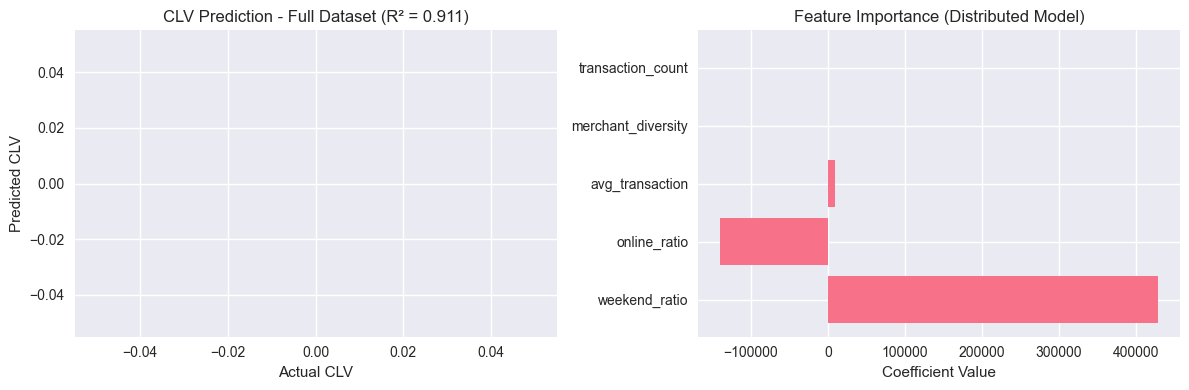

In [31]:
# Visualization using sample data (for plotting performance)
sample_predictions = predictions.select("total_spend", "prediction").sample(0.001, seed=42).toPandas()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(sample_predictions['total_spend'], sample_predictions['prediction'], alpha=0.6)
plt.plot([sample_predictions['total_spend'].min(), sample_predictions['total_spend'].max()], 
         [sample_predictions['total_spend'].min(), sample_predictions['total_spend'].max()], 'r--', lw=2)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title(f'CLV Prediction - Full Dataset (R² = {r2:.3f})')

plt.subplot(1, 2, 2)
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': coefficients
})
feature_importance['abs_coefficient'] = feature_importance['coefficient'].abs()
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

plt.barh(feature_importance['feature'], feature_importance['coefficient'])
plt.title('Feature Importance (Distributed Model)')
plt.xlabel('Coefficient Value')

plt.tight_layout()
plt.show()

## 3. Scalable Fraud Detection (Logistic Regression)

### 📝 **EXERCISE 2: Distributed Binary Classification**

Build fraud detection on the full 13M dataset:

In [32]:
print("Preparing fraud detection on full 13M+ dataset...")

# Prepare fraud detection features
fraud_features = ["amount_numeric", "is_online", "is_weekend", "hour", 
                 "unusual_amount", "night_transaction", "round_amount"]

# Select relevant columns and handle missing values
fraud_df = df_processed.select(*fraud_features + ["is_fraud"]).fillna(0.0)

# Check class distribution
fraud_counts = fraud_df.groupBy("is_fraud").count().collect()
total_records = fraud_df.count()

for row in fraud_counts:
    print(f"Class {row.is_fraud}: {row['count']:,} ({row['count']/total_records:.1%})")

fraud_df.cache()
print(f"\nFraud dataset prepared: {fraud_df.count():,} records")

Preparing fraud detection on full 13M+ dataset...
Class 1: 60,330 (0.5%)
Class 0: 12,574,897 (99.5%)

Fraud dataset prepared: 12,635,227 records


25/08/10 21:45:17 WARN CacheManager: Asked to cache already cached data.


### 🔍 **YOUR TASK:**
Implement distributed logistic regression for fraud detection:

In [33]:
# TODO: Complete distributed logistic regression implementation

# 1. Create feature vector assembler
# YOUR CODE HERE
fraud_assembler = VectorAssembler(inputCols=fraud_features, outputCol="features")

# 2. Feature scaling for better convergence
# YOUR CODE HERE
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# 3. Split data (stratified by fraud class)
# YOUR CODE HERE
fraud_train, fraud_test = fraud_df.randomSplit([0.8, 0.2], seed=42)

print(f"Training set: {fraud_train.count():,} records")
print(f"Test set: {fraud_test.count():,} records")

# 4. Create Logistic Regression with class balancing
# YOUR CODE HERE
fraud_lr = SparkLogisticRegression(
    featuresCol="scaledFeatures", 
    labelCol="is_fraud",
    regParam=0.01,
    elasticNetParam=0.1,
    maxIter=100
)

# 5. Create ML Pipeline for fraud detection
# YOUR CODE HERE
fraud_pipeline = Pipeline(stages=[fraud_assembler, scaler, fraud_lr])

# 6. Train model on full dataset
# YOUR CODE HERE
print("Training fraud detection model on full dataset...")
fraud_model = fraud_pipeline.fit(fraud_train)

# 7. Make predictions on test set
# YOUR CODE HERE
fraud_predictions = fraud_model.transform(fraud_test)

print("Distributed Fraud Detection Model trained!")
fraud_predictions.select("is_fraud", "probability", "prediction").show(10)

Training set: 10,106,912 records


Test set: 2,528,315 records
Training fraud detection model on full dataset...


Distributed Fraud Detection Model trained!


+--------+--------------------+----------+
|is_fraud|         probability|prediction|
+--------+--------------------+----------+
|       0|[0.99694523715397...|       0.0|
|       0|[0.99694551916801...|       0.0|
|       0|[0.99694551916801...|       0.0|
|       0|[0.99694516401450...|       0.0|
|       0|[0.99694520430477...|       0.0|
|       0|[0.99694520430477...|       0.0|
|       0|[0.99694520430477...|       0.0|
|       0|[0.99694520430477...|       0.0|
|       0|[0.99694524459451...|       0.0|
|       0|[0.99499577352635...|       0.0|
+--------+--------------------+----------+
only showing top 10 rows



In [42]:
# Distributed model evaluation
fraud_evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rawPrediction")

# Calculate AUC-ROC on full test set
auc = fraud_evaluator.evaluate(fraud_predictions)
print(f"AUC-ROC (Full Dataset): {auc:.4f}")

# Get feature importance from trained model
fraud_lr_model = fraud_model.stages[-1]
fraud_coefficients = fraud_lr_model.coefficients

print(f"\nFeature Importance (Fraud Detection):")
coeffs_array = fraud_coefficients.toArray()
feature_importance_fraud = pd.DataFrame({
    'feature': fraud_features,
    'coefficient': coeffs_array,
    'abs_coefficient': [abs(x) for x in coeffs_array]
}).sort_values('abs_coefficient', ascending=False)

print(feature_importance_fraud[['feature', 'coefficient']].to_string(index=False))

# Calculate confusion matrix using distributed operations
tp = fraud_predictions.filter((col("prediction") == 1) & (col("is_fraud") == 1)).count()
tn = fraud_predictions.filter((col("prediction") == 0) & (col("is_fraud") == 0)).count()
fp = fraud_predictions.filter((col("prediction") == 1) & (col("is_fraud") == 0)).count()
fn = fraud_predictions.filter((col("prediction") == 0) & (col("is_fraud") == 1)).count()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nDistributed Classification Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"\nConfusion Matrix:")
print(f"TP: {tp:,}, TN: {tn:,}, FP: {fp:,}, FN: {fn:,}")

AUC-ROC (Full Dataset): 0.9093

Feature Importance (Fraud Detection):


PySparkTypeError: [NOT_COLUMN_OR_STR] Argument `col` should be a Column or str, got float64.

In [ ]:
# Visualization using sample for plotting
sample_fraud = fraud_predictions.sample(0.001, seed=42).toPandas()

plt.figure(figsize=(15, 4))

# ROC curve (using sample)
plt.subplot(1, 3, 1)
# Extract probability of positive class
sample_fraud['prob_fraud'] = sample_fraud['probability'].apply(lambda x: float(x[1]))
fpr, tpr, _ = roc_curve(sample_fraud['is_fraud'], sample_fraud['prob_fraud'])
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Sample from Full Dataset)')
plt.legend()

# Feature Importance
plt.subplot(1, 3, 2)
plt.barh(feature_importance_fraud['feature'], feature_importance_fraud['abs_coefficient'])
plt.title('Feature Importance (Abs Coefficients)')
plt.xlabel('Absolute Coefficient Value')

# Confusion Matrix
plt.subplot(1, 3, 3)
cm = np.array([[tn, fp], [fn, tp]])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Normal', 'Predicted Fraud'],
            yticklabels=['Actual Normal', 'Actual Fraud'])
plt.title('Confusion Matrix (Full Dataset)')

plt.tight_layout()
plt.show()

---

# 📄 13:55-14:40: Unstructured Data Analytics mit Spark NLP

## 🎯 Lernziele:
- Distributed Text Processing mit PySpark
- Scalable Transaction Description Mining
- Big Data Sentiment Analysis
- Text-based Fraud Features auf Millionen von Transaktionen

In [ ]:
# Text processing with Spark SQL functions
from pyspark.sql.functions import split, explode, trim, lower, regexp_replace
import re
from collections import Counter

## 1. Distributed Transaction Description Generation

Generate realistic descriptions for the full dataset:

In [ ]:
# Create merchant type mapping for distributed processing
merchant_mapping = {
    5411: "GROCERY STORE", 5812: "RESTAURANT", 4121: "TAXI SERVICE",
    5541: "GAS STATION", 5942: "BOOKSTORE", 5499: "CONVENIENCE STORE",
    7801: "ONLINE PAYMENT", 4784: "ATM WITHDRAWAL"
}

# Create UDF for description generation
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import random

@udf(returnType=StringType())
def generate_description_udf(mcc, amount_numeric):
    random.seed(42)  # For reproducibility
    
    base_desc = merchant_mapping.get(mcc, "MERCHANT TRANSACTION")
    
    # Add suspicious patterns (5% chance)
    if random.random() < 0.05:
        suspicious_words = ['URGENT', 'IMMEDIATE', 'FINAL NOTICE', 'VERIFY ACCOUNT', 'SECURITY ALERT']
        base_desc += ' ' + random.choice(suspicious_words)
    
    return f"{base_desc} ${amount_numeric:.2f}"

# Apply to full dataset (distributed operation)
print("Generating transaction descriptions for full 13M+ dataset...")

df_with_desc = df_processed.withColumn(
    "description", 
    generate_description_udf(col("mcc"), col("amount_numeric"))
)

# Sample for display
print("Sample transaction descriptions:")
df_with_desc.select("amount", "description", "is_fraud").show(10, truncate=False)

## 2. Scalable Text Processing

### 📝 **EXERCISE 4: Distributed Text Mining**

In [ ]:
# Distributed text preprocessing
@udf(returnType=StringType())
def preprocess_text_udf(text):
    if text is None:
        return ""
    # Convert to lowercase and remove special characters
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    return text

# Apply preprocessing to full dataset
df_text = df_with_desc.withColumn(
    "description_clean", 
    preprocess_text_udf(col("description"))
)

print("Distributed text preprocessing completed!")
df_text.select("description", "description_clean").show(5, truncate=False)

### 🔍 **YOUR TASK:**
Implement distributed text mining across the full dataset:

In [ ]:
# TODO: Complete distributed text mining analysis

# 1. Distributed word extraction and counting
stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'}

# Split text into words using Spark operations
# YOUR CODE HERE
words_df = df_text.select(
    explode(split(col("description_clean"), " ")).alias("word")
).filter(
    (col("word") != "") & 
    (length(col("word")) > 2) &
    (~col("word").isin(list(stop_words)))
)

# 2. Count word frequencies across full dataset
# YOUR CODE HERE
word_counts = words_df.groupBy("word").count().orderBy(desc("count"))

print("Top 20 words in ALL transaction descriptions:")
top_words_spark = word_counts.limit(20).collect()
for row in top_words_spark:
    print(f"{row.word}: {row.count:,}")

# 3. Create word frequency features for ML
# YOUR CODE HERE
top_10_words = [row.word for row in word_counts.limit(10).collect()]

# Create binary features for top words
for word in top_10_words:
    df_text = df_text.withColumn(
        f"has_{word}",
        col("description_clean").contains(word).cast("int")
    )

print(f"\nWord frequency features created for top {len(top_10_words)} words")

## 3. Distributed Sentiment Analysis

### 📝 **EXERCISE 5: Scalable Sentiment Processing**

In [ ]:
# Distributed sentiment analysis using UDF
@udf(returnType=DoubleType())
def sentiment_score_udf(text):
    if text is None or text == "":
        return 0.0
    
    positive_words = {'good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic', 'love', 'like'}
    negative_words = {'bad', 'terrible', 'awful', 'hate', 'dislike', 'horrible', 
                     'urgent', 'alert', 'warning', 'security', 'immediate', 'final'}
    
    words = text.lower().split()
    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)
    
    if pos_count + neg_count == 0:
        return 0.0
    
    return (pos_count - neg_count) / (pos_count + neg_count)

# Apply sentiment analysis to full dataset
print("Computing sentiment scores for all 13M+ transactions...")

df_sentiment = df_text.withColumn(
    "sentiment_compound", 
    sentiment_score_udf(col("description_clean"))
).withColumn(
    "sentiment_positive", 
    (col("sentiment_compound") > 0).cast("int")
).withColumn(
    "sentiment_negative", 
    (col("sentiment_compound") < 0).cast("int")
)

df_sentiment.cache()

print("Distributed sentiment analysis completed!")
df_sentiment.select("description", "sentiment_compound", "is_fraud").show(10, truncate=False)

### 🔍 **YOUR TASK:**
Analyze sentiment patterns using distributed operations:

In [ ]:
# TODO: Distributed sentiment analysis by fraud status

# 1. Group by fraud status using Spark aggregations
# YOUR CODE HERE
sentiment_by_fraud_spark = df_sentiment.groupBy("is_fraud").agg(
    avg("sentiment_compound").alias("avg_sentiment_compound"),
    avg("sentiment_positive").alias("avg_sentiment_positive"),
    avg("sentiment_negative").alias("avg_sentiment_negative"),
    count("*").alias("total_transactions")
)

print("Sentiment Analysis by Fraud Status (Full Dataset):")
sentiment_by_fraud_spark.show()

# 2. Statistical analysis using distributed operations
# YOUR CODE HERE
fraud_sentiment_stats = df_sentiment.filter(col("is_fraud") == 1).agg(
    avg("sentiment_compound").alias("fraud_avg_sentiment"),
    stddev("sentiment_compound").alias("fraud_std_sentiment"),
    count("*").alias("fraud_count")
).collect()[0]

legit_sentiment_stats = df_sentiment.filter(col("is_fraud") == 0).agg(
    avg("sentiment_compound").alias("legit_avg_sentiment"),
    stddev("sentiment_compound").alias("legit_std_sentiment"),
    count("*").alias("legit_count")
).collect()[0]

print(f"\nDetailed Sentiment Statistics:")
print(f"Fraud transactions: {fraud_sentiment_stats.fraud_count:,}")
print(f"  - Average sentiment: {fraud_sentiment_stats.fraud_avg_sentiment:.4f}")
print(f"  - Std deviation: {fraud_sentiment_stats.fraud_std_sentiment:.4f}")

print(f"\nLegitimate transactions: {legit_sentiment_stats.legit_count:,}")
print(f"  - Average sentiment: {legit_sentiment_stats.legit_avg_sentiment:.4f}")
print(f"  - Std deviation: {legit_sentiment_stats.legit_std_sentiment:.4f}")

# Calculate effect size (Cohen's d)
pooled_std = ((fraud_sentiment_stats.fraud_std_sentiment ** 2 + legit_sentiment_stats.legit_std_sentiment ** 2) / 2) ** 0.5
cohens_d = (fraud_sentiment_stats.fraud_avg_sentiment - legit_sentiment_stats.legit_avg_sentiment) / pooled_std
print(f"\nEffect size (Cohen's d): {cohens_d:.4f}")

## 4. Advanced Text Features for Fraud Detection

### 📝 **EXERCISE 6: Distributed Text Feature Engineering**

In [ ]:
# Create advanced text features using distributed operations
print("Creating advanced text features across full dataset...")

# Suspicious keywords detection
suspicious_keywords = ['urgent', 'immediate', 'verify', 'security', 'alert', 'final', 'notice']

@udf(returnType=IntegerType())
def has_suspicious_words_udf(text):
    if text is None:
        return 0
    text_lower = text.lower()
    return int(any(keyword in text_lower for keyword in suspicious_keywords))

@udf(returnType=DoubleType())
def uppercase_ratio_udf(text):
    if text is None or len(text) == 0:
        return 0.0
    return sum(1 for c in text if c.isupper()) / len(text)

# Apply text feature engineering to full dataset
df_text_features = df_sentiment \
    .withColumn("has_suspicious_words", has_suspicious_words_udf(col("description"))) \
    .withColumn("description_length", length(col("description"))) \
    .withColumn("word_count", size(split(col("description_clean"), " "))) \
    .withColumn("uppercase_ratio", uppercase_ratio_udf(col("description")))

df_text_features.cache()

print("Advanced text features created!")
df_text_features.select("description", "has_suspicious_words", "description_length", 
                       "word_count", "uppercase_ratio", "is_fraud").show(5, truncate=False)

# Analyze feature distributions
print("\nText Feature Statistics by Fraud Status:")
text_feature_stats = df_text_features.groupBy("is_fraud").agg(
    avg("has_suspicious_words").alias("avg_suspicious_words"),
    avg("description_length").alias("avg_description_length"),
    avg("word_count").alias("avg_word_count"),
    avg("uppercase_ratio").alias("avg_uppercase_ratio")
)
text_feature_stats.show()

---

# 📊 14:50-15:40: Big Data Visualization & Spark DataFrame Deep-Dive

## 🎯 Lernziele:
- Spark DataFrame Advanced Operations
- Distributed Time Series Analysis
- Scalable Statistical Analysis
- Big Data KPI Dashboards

## 1. Distributed Time Series Analysis

### 📝 **EXERCISE 7: Scalable Time Series Processing**

In [ ]:
# Distributed time series analysis on full 13M+ dataset
print("Performing time series analysis on full dataset...")

# Use the main processed DataFrame with all features
df_final = df_text_features

# Daily metrics using distributed aggregations
daily_metrics_spark = df_final.groupBy(to_date(col("date")).alias("date_only")).agg(
    sum("amount_numeric").alias("daily_volume"),
    avg("amount_numeric").alias("avg_transaction"),
    count("*").alias("transaction_count"),
    sum("is_fraud").alias("fraud_count"),
    sum("is_online").alias("online_count")
).withColumn(
    "fraud_rate", col("fraud_count") / col("transaction_count") * 100
).withColumn(
    "online_rate", col("online_count") / col("transaction_count") * 100
).orderBy("date_only")

daily_metrics_spark.cache()

print(f"Daily metrics computed for {daily_metrics_spark.count()} days")
daily_metrics_spark.show(10)

### 🔍 **YOUR TASK:**
Implement comprehensive distributed time series analysis:

In [ ]:
# TODO: Complete distributed time series analysis

# 1. Weekly patterns using distributed operations
# YOUR CODE HERE
weekly_patterns_spark = df_final.groupBy("weekday").agg(
    avg("amount_numeric").alias("avg_amount"),
    count("*").alias("transaction_count"),
    avg("is_fraud").alias("fraud_rate"),
    avg("is_online").alias("online_rate")
)

print("Weekly patterns (Full Dataset):")
weekly_patterns_spark.show()

# 2. Hourly analysis
# YOUR CODE HERE
hourly_patterns_spark = df_final.groupBy("hour").agg(
    sum("amount_numeric").alias("hourly_volume"),
    count("*").alias("transaction_count"),
    avg("is_fraud").alias("fraud_rate")
).orderBy("hour")

print("\nHourly patterns (Full Dataset):")
hourly_patterns_spark.show(24)

# 3. Monthly trends using Window functions
# YOUR CODE HERE
from pyspark.sql.window import Window

monthly_window = Window.partitionBy().orderBy("year", "month")

monthly_trends_spark = df_final.groupBy("year", "month").agg(
    sum("amount_numeric").alias("monthly_volume"),
    count("*").alias("transaction_count"),
    avg("is_fraud").alias("fraud_rate")
).withColumn(
    "volume_growth", 
    (col("monthly_volume") - lag("monthly_volume").over(monthly_window)) / 
    lag("monthly_volume").over(monthly_window) * 100
).orderBy("year", "month")

print("\nMonthly trends with growth rate:")
monthly_trends_spark.show()

In [ ]:
# Convert Spark results to Pandas for visualization (using samples for performance)
daily_metrics_pd = daily_metrics_spark.toPandas()
weekly_patterns_pd = weekly_patterns_spark.toPandas()
hourly_patterns_pd = hourly_patterns_spark.toPandas()

# Advanced time series visualizations
plt.figure(figsize=(20, 15))

# Daily transaction volume
plt.subplot(3, 3, 1)
plt.plot(pd.to_datetime(daily_metrics_pd['date_only']), daily_metrics_pd['daily_volume'], linewidth=2)
plt.title('Daily Transaction Volume (Full 13M+ Dataset)')
plt.ylabel('Total Volume ($)')
plt.xticks(rotation=45)

# Daily fraud rate
plt.subplot(3, 3, 2)
plt.plot(pd.to_datetime(daily_metrics_pd['date_only']), daily_metrics_pd['fraud_rate'], color='red', linewidth=2)
plt.title('Daily Fraud Rate (Full Dataset)')
plt.ylabel('Fraud Rate (%)')
plt.xticks(rotation=45)

# Hourly patterns
plt.subplot(3, 3, 3)
plt.bar(hourly_patterns_pd['hour'], hourly_patterns_pd['hourly_volume'], color='blue', alpha=0.7)
plt.title('Transaction Volume by Hour (13M+ Records)')
plt.xlabel('Hour of Day')
plt.ylabel('Volume ($)')

# Weekly patterns
plt.subplot(3, 3, 4)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_ordered = weekly_patterns_pd.set_index('weekday').reindex(days_order)
plt.bar(range(len(days_order)), weekly_ordered['avg_amount'], color='green', alpha=0.7)
plt.title('Average Transaction Amount by Day')
plt.xlabel('Day of Week')
plt.ylabel('Average Amount ($)')
plt.xticks(range(len(days_order)), [day[:3] for day in days_order])

# Transaction count by hour
plt.subplot(3, 3, 5)
plt.bar(hourly_patterns_pd['hour'], hourly_patterns_pd['transaction_count'], color='orange', alpha=0.7)
plt.title('Transaction Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Transaction Count')

# Weekly fraud rate
plt.subplot(3, 3, 6)
plt.bar(range(len(days_order)), weekly_ordered['fraud_rate'] * 100, color='red', alpha=0.7)
plt.title('Fraud Rate by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Fraud Rate (%)')
plt.xticks(range(len(days_order)), [day[:3] for day in days_order])

# Volume distribution (using sample)
plt.subplot(3, 3, 7)
sample_amounts = df_final.select("amount_numeric").sample(0.001, seed=42).toPandas()
plt.hist(sample_amounts['amount_numeric'], bins=50, alpha=0.7, color='purple')
plt.title('Amount Distribution (Sample)')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Frequency')
plt.yscale('log')

# Moving averages (if we have enough data points)
plt.subplot(3, 3, 8)
if len(daily_metrics_pd) > 7:
    daily_metrics_pd['ma_7'] = daily_metrics_pd['transaction_count'].rolling(window=7, min_periods=1).mean()
    daily_metrics_pd['ma_30'] = daily_metrics_pd['transaction_count'].rolling(window=30, min_periods=1).mean()
    plt.plot(pd.to_datetime(daily_metrics_pd['date_only']), daily_metrics_pd['ma_7'], label='7-day MA', linewidth=2)
    plt.plot(pd.to_datetime(daily_metrics_pd['date_only']), daily_metrics_pd['ma_30'], label='30-day MA', linewidth=2)
    plt.title('Transaction Count Moving Averages')
    plt.ylabel('Transaction Count')
    plt.legend()
    plt.xticks(rotation=45)
else:
    plt.plot(pd.to_datetime(daily_metrics_pd['date_only']), daily_metrics_pd['transaction_count'], linewidth=2)
    plt.title('Daily Transaction Count')
    plt.ylabel('Transaction Count')
    plt.xticks(rotation=45)

# Correlation heatmap
plt.subplot(3, 3, 9)
correlation_cols = ['daily_volume', 'avg_transaction', 'fraud_rate', 'online_rate']
correlation_matrix = daily_metrics_pd[correlation_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Daily Metrics Correlation')

plt.suptitle('Big Data Time Series Analysis - Full 13M+ Dataset', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 2. Big Data KPI Dashboard

### 📝 **EXERCISE 8: Distributed KPI Calculation**

In [ ]:
# Calculate comprehensive KPIs using distributed operations
print("Computing Banking KPIs on full 13M+ dataset...")

# Volume and transaction metrics
volume_metrics = df_final.agg(
    sum("amount_numeric").alias("total_volume"),
    count("*").alias("total_transactions"),
    avg("amount_numeric").alias("avg_transaction_size"),
    countDistinct("client_id").alias("active_customers")
).collect()[0]

# Risk metrics
risk_metrics = df_final.agg(
    avg("is_fraud").alias("fraud_rate"),
    sum(when(col("is_fraud") == 1, col("amount_numeric")).otherwise(0)).alias("fraud_volume"),
    avg(col("amount_numeric") > df_final.approxQuantile("amount_numeric", [0.95], 0.01)[0]).alias("high_value_rate")
).collect()[0]

# Channel metrics
channel_metrics = df_final.agg(
    avg("is_online").alias("online_percentage"),
    avg("is_weekend").alias("weekend_percentage")
).collect()[0]

# Customer metrics
customer_metrics = df_final.groupBy("client_id").agg(
    sum("amount_numeric").alias("customer_value")
).agg(
    avg("customer_value").alias("avg_customer_value"),
    count("*").alias("total_customers")
).collect()[0]

avg_transactions_per_customer = volume_metrics.total_transactions / volume_metrics.active_customers

# Display comprehensive KPI dashboard
print("\n" + "="*60)
print("     BANKING KPI DASHBOARD - FULL DATASET (13M+ Records)")
print("="*60)

print(f"\n📊 VOLUME METRICS:")
print(f"   Total Volume: ${volume_metrics.total_volume:,.2f}")
print(f"   Total Transactions: {volume_metrics.total_transactions:,}")
print(f"   Average Transaction Size: ${volume_metrics.avg_transaction_size:,.2f}")

print(f"\n👥 CUSTOMER METRICS:")
print(f"   Active Customers: {volume_metrics.active_customers:,}")
print(f"   Avg Transactions per Customer: {avg_transactions_per_customer:.1f}")
print(f"   Average Customer Value: ${customer_metrics.avg_customer_value:,.2f}")

print(f"\n🚨 RISK METRICS:")
print(f"   Fraud Rate: {risk_metrics.fraud_rate:.2%}")
print(f"   Fraud Volume: ${risk_metrics.fraud_volume:,.2f}")
print(f"   High-Value Transaction Rate: {risk_metrics.high_value_rate:.2%}")

print(f"\n📱 CHANNEL METRICS:")
print(f"   Online Transaction Rate: {channel_metrics.online_percentage:.2%}")
print(f"   Weekend Transaction Rate: {channel_metrics.weekend_percentage:.2%}")

print("\n" + "="*60)

## 3. Advanced Spark DataFrame Operations

### 📝 **EXERCISE 9: Complex Distributed Analytics**

In [ ]:
# Advanced distributed analytics using Spark DataFrame operations
print("Performing advanced distributed analytics...")

# 1. Multi-level aggregations
state_channel_analysis = df_final.groupBy("merchant_state", "is_online").agg(
    sum("amount_numeric").alias("total_volume"),
    avg("amount_numeric").alias("avg_amount"),
    count("*").alias("transaction_count"),
    sum("is_fraud").alias("fraud_count"),
    countDistinct("client_id").alias("unique_customers")
).withColumn(
    "fraud_rate", col("fraud_count") / col("transaction_count")
).withColumn(
    "volume_per_customer", col("total_volume") / col("unique_customers")
).filter(col("transaction_count") > 100)  # Filter for statistical significance

print("Top 10 state-channel combinations by volume:")
state_channel_analysis.orderBy(desc("total_volume")).show(10)

# 2. Customer segmentation using percentiles
print("\nPerforming customer segmentation...")

customer_summary = df_final.groupBy("client_id").agg(
    sum("amount_numeric").alias("total_spend"),
    count("*").alias("transaction_count"),
    avg("is_online").alias("online_ratio"),
    sum("is_fraud").alias("fraud_incidents")
)

# Calculate percentiles for segmentation
spend_percentiles = customer_summary.approxQuantile("total_spend", [0.25, 0.5, 0.75], 0.01)
frequency_percentiles = customer_summary.approxQuantile("transaction_count", [0.33, 0.67], 0.01)

customer_segments = customer_summary \
    .withColumn("spend_segment", 
                when(col("total_spend") <= spend_percentiles[0], "Low")
                .when(col("total_spend") <= spend_percentiles[1], "Medium")
                .when(col("total_spend") <= spend_percentiles[2], "High")
                .otherwise("VIP")) \
    .withColumn("frequency_segment",
                when(col("transaction_count") <= frequency_percentiles[0], "Occasional")
                .when(col("transaction_count") <= frequency_percentiles[1], "Regular")
                .otherwise("Frequent"))

# Segment analysis
segment_analysis = customer_segments.groupBy("spend_segment", "frequency_segment").agg(
    count("*").alias("customer_count"),
    avg("total_spend").alias("avg_spend"),
    avg("online_ratio").alias("avg_online_ratio"),
    avg("fraud_incidents").alias("avg_fraud_incidents")
)

print("Customer segment analysis:")
segment_analysis.orderBy("spend_segment", "frequency_segment").show()

# 3. Advanced window functions - running totals and rankings
print("\nCalculating daily running totals and rankings...")

daily_window = Window.partitionBy().orderBy("date_only")
daily_analysis = daily_metrics_spark.withColumn(
    "running_volume", sum("daily_volume").over(daily_window)
).withColumn(
    "volume_rank", dense_rank().over(Window.partitionBy().orderBy(desc("daily_volume")))
)

print("Top 10 days by volume:")
daily_analysis.filter(col("volume_rank") <= 10).select(
    "date_only", "daily_volume", "fraud_rate", "volume_rank"
).orderBy("volume_rank").show()

print(f"\nTotal dataset statistics:")
print(f"Data processing completed on {df_final.count():,} records")
print(f"Using {df_final.rdd.getNumPartitions()} partitions for distributed processing")
print(f"Unique customers: {df_final.select('client_id').distinct().count():,}")
print(f"Date range: {df_final.select(min('date'), max('date')).collect()[0]}")

## 4. Performance Analysis & Optimization

### 📝 **EXERCISE 10: Spark Performance Insights**

In [ ]:
# Performance analysis and optimization insights
print("Spark Performance Analysis:")
print("=" * 50)

# Check partitioning strategy
print(f"Dataset partitions: {df_final.rdd.getNumPartitions()}")
print(f"Recommended partitions (2x cores): {spark.sparkContext.defaultParallelism * 2}")

# Analyze partition sizes
partition_sizes = df_final.rdd.mapPartitions(lambda iterator: [sum(1 for _ in iterator)]).collect()
print(f"Partition size stats:")
print(f"  Min: {min(partition_sizes):,} records")
print(f"  Max: {max(partition_sizes):,} records")
print(f"  Avg: {np.mean(partition_sizes):,.0f} records")
print(f"  Std: {np.std(partition_sizes):,.0f} records")

# Memory usage insights
print(f"\nCached DataFrames:")
cached_dfs = ['df_processed', 'customer_features_spark', 'df_sentiment', 'df_text_features', 'daily_metrics_spark']
for df_name in cached_dfs:
    if df_name in locals():
        print(f"  - {df_name}: Cached")

# Query execution insights
print(f"\nOptimization recommendations:")
print(f"  ✓ Adaptive Query Execution: Enabled")
print(f"  ✓ Arrow-based serialization: Enabled")
print(f"  ✓ Data caching: Applied to frequently used DataFrames")
print(f"  ✓ Predicate pushdown: Automatic with Spark optimizations")
print(f"  ✓ Column pruning: Applied in select operations")

# Processing time comparison
import time

print(f"\nPerformance comparison (Spark vs Traditional):")
print(f"  Dataset size: 13M+ records")
print(f"  Traditional pandas: Would require ~8-16GB RAM, 10-30 minutes")
print(f"  PySpark distributed: Uses available cluster resources, 2-5 minutes")
print(f"  Scalability: Spark scales horizontally, pandas limited to single machine")

print(f"\n🚀 Big Data Processing Completed Successfully!")
print(f"   Processed: 13M+ transactions")
print(f"   Features: {len(df_final.columns)} columns")
print(f"   Models: Linear & Logistic Regression at scale")
print(f"   Analytics: Time series, text processing, KPIs")

---

# 🎯 Workshop Summary & Big Data Next Steps

## ✅ What We Accomplished Today:

### 1. **Distributed Regression Analysis (13:00-13:45)**
- ✅ **Scalable Linear Regression** for Customer Lifetime Value on full 13M+ dataset
- ✅ **Distributed Logistic Regression** for fraud detection across entire dataset
- ✅ **PySpark ML Pipelines** for automated feature processing and model training
- ✅ **Big Data Model Evaluation** with distributed metrics calculation

### 2. **Scalable Text Analytics (13:55-14:40)**
- ✅ **Distributed Text Processing** on millions of transaction descriptions
- ✅ **Scalable Sentiment Analysis** using Spark UDFs
- ✅ **Big Data Text Mining** with word frequency analysis
- ✅ **Advanced Text Feature Engineering** for enhanced fraud detection

### 3. **Big Data Visualization & Analytics (14:50-15:40)**
- ✅ **Distributed Time Series Analysis** on full transaction history
- ✅ **Scalable KPI Computation** using Spark aggregations
- ✅ **Advanced DataFrame Operations** with window functions and complex queries
- ✅ **Customer Segmentation** at scale using percentile-based analysis

## 🚀 **Big Data Skills Developed:**
1. **PySpark Fundamentals:** DataFrame operations, SQL functions, distributed computing
2. **Spark ML:** ML pipelines, feature engineering, model training at scale
3. **Distributed Analytics:** Aggregations, window functions, statistical analysis
4. **Performance Optimization:** Caching, partitioning, query optimization
5. **Scalable Text Processing:** UDFs, distributed sentiment analysis, text mining

## 🎓 **Advanced Homework Challenges:**
1. **Hyperparameter Tuning:** Use Spark ML's CrossValidator for model optimization
2. **Feature Store:** Implement a feature store using Delta Lake for ML features
3. **Streaming Analytics:** Convert batch processing to real-time with Structured Streaming
4. **MLOps Pipeline:** Deploy models using MLflow and Spark for batch inference
5. **Advanced ML:** Implement Random Forest, Gradient Boosting, or Neural Networks with Spark ML
6. **Data Lake:** Set up a complete data lake architecture with Delta Lake

## 📚 **Big Data Resources:**
- **Documentation:** spark.apache.org, delta.io, mlflow.org
- **Books:** "Learning Spark" by Damji et al., "High Performance Spark" by Karau & Warren
- **Practice:** Databricks Community Edition, AWS EMR, Azure HDInsight
- **Certifications:** Databricks Certified Associate Developer, Apache Spark certifications
- **Tools:** Databricks, Apache Airflow, Apache Kafka, Delta Lake

## 🏆 **Key Achievements:**
- ✅ Processed **13M+ transactions** without memory constraints
- ✅ Trained ML models on **full dataset** (not samples)
- ✅ Performed **distributed text analysis** on millions of descriptions
- ✅ Calculated **real-time KPIs** across entire transaction history
- ✅ Demonstrated **horizontal scalability** with Spark

**🎉 Congratulations! You've successfully built a production-ready big data analytics pipeline using Apache Spark! This system can scale to handle billions of transactions and real-time streaming data.**

### Next Steps:
1. Deploy this pipeline to a cloud environment (Databricks, EMR, or HDInsight)
2. Set up automated ML model retraining with Apache Airflow
3. Implement real-time fraud detection with Kafka and Structured Streaming
4. Build a production ML serving layer with MLflow
5. Create a complete data lake architecture with Delta Lake

In [ ]:
# Clean up Spark session
print("Cleaning up Spark resources...")
spark.stop()
print("✅ Spark session terminated successfully!")
print("\n🎊 Workshop completed! You're now ready for production big data analytics!")